In [1]:
import torch
from torch import nn

In [ ]:
!wget https://www.cis.upenn.edu/~jshi/ped_html/PennFudanPed.zip
!unzip PennFudanPed.zip

--2021-07-08 04:19:28--  https://www.cis.upenn.edu/~jshi/ped_html/PennFudanPed.zip
Resolving www.cis.upenn.edu (www.cis.upenn.edu)... 158.130.69.163, 2607:f470:8:64:5ea5::d
Connecting to www.cis.upenn.edu (www.cis.upenn.edu)|158.130.69.163|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 53723336 (51M) [application/zip]
Saving to: ‘PennFudanPed.zip.3’

PennFudanPed.zip.3  100%[===================>]  51.23M   103MB/s    in 0.5s    

2021-07-08 04:19:29 (103 MB/s) - ‘PennFudanPed.zip.3’ saved [53723336/53723336]

Archive:  PennFudanPed.zip
replace PennFudanPed/added-object-list.txt? [y]es, [n]o, [A]ll, [N]one, [r]ename: N


In [2]:
import matplotlib.pyplot as plt
import os
import numpy as np
from PIL import Image
class PedDataset(torch.utils.data.Dataset):
  def __init__(self, root):
    self.root = root
    self.names = [fname.split('.')[0] for fname in os.listdir(os.path.join(self.root, 'Annotation'))]
    print(self.names)

  def __getitem__(self, idx):
    name = self.names[idx]
    imgpath = os.path.join(self.root, 'PNGImages', name+'.png')
    img = np.array(Image.open(imgpath))
    
    maskpath = os.path.join(self.root, 'PedMasks', name+'_mask.png')
    mask = np.array(Image.open(maskpath))
    #plt.imshow(np.array(mask))
    
    mask_indices = np.unique(mask)[1:]
    masklist = (mask[None, :, :] == mask_indices[:, None, None]) # num_instances H W
    print(masklist.shape)
    boxlist = []
    for i in range(len(masklist)):
      mask = masklist[i]
      y, x = np.nonzero(mask)
      xx = np.min(x)
      yx = np.max(x)
      xy = np.min(y)
      yy = np.max(y)
      print(xx, xy, yx, yy)
      boxlist.append((xx, xy, yx, yy))

    clslist = []
    for mask in masklist:
      clslist.append(1)

    return img, clslist, boxlist, masklist
  def __len__(self):
    return len(self.names)
pd = PedDataset('PennFudanPed')
a = pd[1]

FileNotFoundError: ignored

In [ ]:
import torchvision
import torch.nn.functional as F
@torch.no_grad()
def collate_fn(batch):
  imgs, clslist, boxlist, masklist = tuple(zip(*batch))
  N = len(batch)
  K = sum([len(G) for G in clslist])

  ###tensoring
  imgs = [torchvision.transforms.functional.to_tensor(img) for img in imgs]
  GT_cls = [torch.tensor(l) for l in clslist]
  GT_box = [torch.tensor(lt) for lt in boxlist]
  GT_mask = [torch.tensor(lt, dtype=torch.float32) for lt in masklist] #[(L Hi Wi)...]
  ###img batching
  for i, img in enumerate(imgs):
    C, H, W = img.shape
    sH =  int(H * 400/min(H, W))
    sW =  int(W * 400/min(H, W))
    scale = 400/min(H, W)
    
    #sH, sW = int(H*scale), int(W*scale)
    print(f'sH: {sH}, sW: {sW}, HW : {H}, {W}')
    img = torchvision.transforms.functional.resize(
        img, size=(sH, sW))
    imgs[i] = img
    print(GT_box[i])
    GT_box[i] = (GT_box[i] * scale).int()
    print('scaled', GT_box[i])
    #print(GT_mask[i].shape) #num_instances H W
    GT_mask[i] = F.interpolate(GT_mask[i][None, :, :, :], size=(sH, sW), mode='nearest')[0]

  maxh = max([img.shape[1] for img in imgs])
  maxw = max([img.shape[2] for img in imgs])
  maxh = int(np.ceil(maxh/32) * 32)
  maxw = int(np.ceil(maxw/32) * 32)
  print(maxh)
  X = torch.zeros(N, C, maxh, maxw)
  for i, img in enumerate(imgs):
    c, h, w = img.shape
    X[i, :c, :h, :w] = img[:, :, :]

  GT_mask_resized = []
  ###resize masking
  batch_indices = torch.tensor([i for i, l in enumerate(clslist) for _ in range(len(l))])

  for i, masks in enumerate(GT_mask):
    GT_mask = torch.zeros(len(masks), 14, 14)
    gt_box = GT_box[i]
    #print(masks.shape)
    for j, mask in enumerate(masks):
      #print(mask.shape)
      boxed_mask = mask[gt_box[j, 0]:gt_box[j, 2]+1, gt_box[j, 1]:gt_box[j, 3]+1]
      #print(boxed_mask.shape)
      resized_mask = F.interpolate(boxed_mask[None, None, :, :], size=(14, 14), mode='nearest')[0][0]
      GT_mask[j] = resized_mask

    GT_mask_resized.append(GT_mask)
  ### create batch_indices
  batch_indices = torch.tensor([i for i, l in enumerate(clslist) for _ in range(len(l))])
  #print(batch_indices.shape)
  return (X, GT_cls, GT_box, GT_mask_resized, batch_indices)
dl = torch.utils.data.DataLoader(
    pd,
    batch_size=2,
    shuffle=False,
    collate_fn=collate_fn
)

In [4]:
class Conv(nn.Module):
  def __init__(self, in_channels, out_channels, kernel_size, stride=1, padding=-1, act=True):
    super().__init__()
    padding = kernel_size // 2 if padding == -1 else padding
    self.conv2d = nn.Conv2d(in_channels, out_channels, kernel_size, stride, padding)
    self.bn = nn.BatchNorm2d(num_features=out_channels)
    self.act_layer = nn.LeakyReLU() if act == True else nn.Identity()

  def forward(self, x):
    x = self.conv2d(x)
    x = self.bn(x)
    x = self.act_layer(x)
    return x

# class Residual(nn.Module):
#   def __init__(self, a, b, now=-1):
#     self.a = a if a >= 0 else now-a
#     self.b = b if b >= 0 else now-b
#   def forward(self, x, flist):
#     x = flist[self.a] + flist[self.b]
#     return x

# class Concat(nn.Module):
#   def __init__(self, a, b):
#     self.a = a
#     self.b = b
#   def forward(self, x, flist):
#     x = torch.cat((flist[self.a], flist[self.b]), dim=1)
#     return x

# class Route(nn.Module):
#   def __init__(self, a):
#     self.a = a
#   def forward(self, x, flist):
#     x = flist[self.a]
#     return x

class Bottleneck(nn.Module):
  def __init__(self, in_channels, out_channels, act=True):
    super().__init__()
    c_ = out_channels // 2
    self.conv1 = Conv(in_channels, c_, 1)
    self.conv2 = Conv(c_, out_channels, 3)
    #self.m = nn.Sequential(*[Conv(out_channels, out_channels, 1) for _ in range(n)])

  def forward(self, x):
    x_ = self.conv1(x)
    x_ = self.conv2(x_)
    return x + x_

class BottleneckCSP(nn.Module):
  def __init__(self, in_channels, out_channels, n=1, act=True):
    super().__init__()
    self.conv = Conv(in_channels, out_channels, 1)
    self.m = nn.Sequential(*[Conv(out_channels, out_channels, 1) for _ in range(n)])

  def forward(self, x):
    
    x = self.conv(x)
    x_ = x.clone()
    x = self.m(x)
    return x

class BottleneckCSP2(nn.Module):
  def __init__(self, in_channels, out_channels, n=1, act=True):
    super().__init__()
    self.conv = Conv(in_channels, out_channels, 1)
    self.m = nn.Sequential(*[Conv(out_channels, out_channels, 1) for _ in range(n)])

  def forward(self, x):
    x = self.conv(x)
    x_ = x.clone()
    x = self.m(x)
    return x + x_

# class Upsample(nn.Module):
#   def __init__(self, size=None, scale_factor=2, mode='nearest'):
#     self.m = nn.Upsample(size, scale_factor, mode)
  
#   def forward(self, x):
#     x = self.m(x)
#     return x

class Concat(nn.Module):
  def __init__(self, dim=1):
    super().__init__()
    self.dim = dim
  
  def forward(self, xs):
    x = torch.cat(xs, dim=self.dim)
    return x

class SPPCSP(nn.Module):
  def __init__(self, in_channels, out_channels, n=1, act=True):
    super().__init__()
    self.conv = Conv(in_channels, out_channels, 1)
    self.m = nn.Sequential(*[Conv(out_channels, out_channels, 1) for _ in range(n)])

  def forward(self, x):
    x = self.conv(x)
    x = self.m(x)
    return x

#BottleneckCSP = Bottleneck
#BottleneckCSP2 = Bottleneck
#BottleneckSPPCSP = Bottleneck

class Detect(nn.Module):
  def __init__(self, nc, anchors=(), ch=()):
    super().__init__()
    self.nc = nc
    self.nl = len(anchors)
    self.na = len(anchors[0])//2
    self.anchors = torch.tensor(anchors).view(self.nl, self.na, 2)
    self.no = self.nc + 4 + 1
    self.convs = [Conv(c1, self.na * (self.nc + 4 + 1), 1, act=False) for c1 in ch]

    self.strides = None
    self.grids = None

  def forward(self, xs):
    for i in range(self.nl):
      x = xs[i] # N C H W
      x = self.convs[i](x)
      N, C, H, W = x.shape
      x = x.view(N, self.na, self.no, H, W).permute(0, 1, 3, 4, 2)
      xs[i] = x
    return xs

  @staticmethod
  def _make_grid(nx=20, ny=20):
    grid_x = torch.arange(nx)
    grid_y = torch.arange(ny)
    grid_x = grid_x[None, :].repeat(ny, 1)
    grid_y = grid_y[:, None].repeat(1, nx)

    grid = torch.stack((grid_x, grid_y), dim=2)
    return grid

In [5]:
# class ModelBlock(nn.Module):
#   def __init__(self, f, n, m, a):
#     super().__init__()
#     self.f = f
#     self.n = n
#     self.m = m
#     self.a = a

#     self.blocks = nn.ModuleList()
#     print(a)
#     for i in range(n):
#       block = self.m(*a)
#       self.blocks.append(block)
    
#   def forward(self, x):
#     for b in self.blocks:
#       x = b(x)
#     return x

In [6]:
#from number module args

nc = 80
anchors = [(10,10, 30,30), (50,50, 70,70), (200,200, 400,400)]
backbone = [[-1, 1, Conv, [32, 3, 1]],  # 0
   [-1, 1, Conv, [64, 3, 2]],  # 1-P1/2
   [-1, 1, Bottleneck, [64]],
   [-1, 1, Conv, [128, 3, 2]],  # 3-P2/4
   [-1, 2, BottleneckCSP, [128]],
   [-1, 1, Conv, [256, 3, 2]],  # 5-P3/8
   [-1, 8, BottleneckCSP, [256]],
   [-1, 1, Conv, [512, 3, 2]],  # 7-P4/16
   [-1, 8, BottleneckCSP, [512]],
   [-1, 1, Conv, [1024, 3, 2]], # 9-P5/32
   [-1, 4, BottleneckCSP, [1024]],  # 10
]

head = [[-1, 1, SPPCSP, [512]], # 11
   [-1, 1, Conv, [256, 1, 1]],
   [-1, 1, nn.Upsample, [None, 2, 'nearest']],
   [8, 1, Conv, [256, 1, 1]], # route backbone P4
   [[-1, -2], 1, Concat, [1]],
   [-1, 2, BottleneckCSP2, [256]], # 16 
   [-1, 1, Conv, [128, 1, 1]],
   [-1, 1, nn.Upsample, [None, 2, 'nearest']],
   [6, 1, Conv, [128, 1, 1]], # route backbone P3
   [[-1, -2], 1, Concat, [1]],
   [-1, 2, BottleneckCSP2, [128]], # 21
   [-1, 1, Conv, [256, 3, 1]],
   [-2, 1, Conv, [256, 3, 2]],
   [[-1, 16], 1, Concat, [1]],  # cat
   [-1, 2, BottleneckCSP2, [256]], # 25
   [-1, 1, Conv, [512, 3, 1]],
   [-2, 1, Conv, [512, 3, 2]],
   [[-1, 11], 1, Concat, [1]],  # cat
   [-1, 2, BottleneckCSP2, [512]], # 29
   [-1, 1, Conv, [1024, 3, 1]],

   [[22,26,30], 1, Detect, [nc, anchors]],   # Detect(P3, P4, P5)
  ]

In [7]:
# a, b, c, d = head[31-11]
# d

In [8]:
class YOLO(nn.Module):
  def __init__(self, backbone, head):
    super().__init__()
    self.backbone = backbone
    self.head = head

    self.blocklist = nn.ModuleList()

    ch = [3]
    for i, block in enumerate(backbone + head):
      f, n, m, a = block
      print(a)
      if isinstance(f, int):
        f = f+1 if f >= 0 else f
      elif isinstance(f, list):
        f = [x+1 if x >= 0 else x for x in f]

      if m in [Conv, Bottleneck, BottleneckCSP, BottleneckCSP2, SPPCSP]:
        c1, c2 = ch[f], a[0]
        a = [c1, c2, *a[1:]]
        
        if m in [BottleneckCSP, BottleneckCSP2, SPPCSP]:
          a.insert(2, n)
          n = 1
      elif m == nn.Upsample:
        c2 = ch[f]
      elif m == Concat:
        c2 = sum([ch[x] for x in f])
        #print([ch[x] for x in f])
      elif m == Detect:
        c1 = [ch[x] for x in f]
        print(a)
        a.insert(2, c1)
        print(a)
      else:
        c2 = -1

      print(i, m, a)
      m_ = nn.Sequential(*[m(*a) for _ in range(n)])
      m_.i, m_.f = i, f
      self.blocklist.append(m_)
      ch.append(c2)


    m = self.blocklist[-1][0] # Detect
    s = 256
    m.strides = torch.tensor([s/x.shape[2] for x in self.forward(torch.zeros(1, 3, s, s))])
    print('m.strides: ', m.strides)
    m.anchors = m.anchors / m.strides.view(-1, 1, 1) # anchors: nl na 2

    #print(ch)
 # @torch.no_grad()
  def forward(self, x):
    y = [x]
    for i, block in enumerate(self.blocklist):
      #print(i, block)
      if i == 0 or block.f == -1:
        x = block(x)
      else:
        if isinstance(block.f, int):
          x = y[block.f]
        elif isinstance(block.f, list):
          #print(block.f)
          #print([y[f].shape for f in block.f])
          x = [y[f] for f in block.f]
        x = block(x)
      if i != 31:
        print(i, x.shape)
      y.append(x)
      
    return x

In [9]:
yolo = YOLO(backbone, head)

[32, 3, 1]
0 <class '__main__.Conv'> [3, 32, 3, 1]
[64, 3, 2]
1 <class '__main__.Conv'> [32, 64, 3, 2]
[64]
2 <class '__main__.Bottleneck'> [64, 64]
[128, 3, 2]
3 <class '__main__.Conv'> [64, 128, 3, 2]
[128]
4 <class '__main__.BottleneckCSP'> [128, 128, 2]
[256, 3, 2]
5 <class '__main__.Conv'> [128, 256, 3, 2]
[256]
6 <class '__main__.BottleneckCSP'> [256, 256, 8]
[512, 3, 2]
7 <class '__main__.Conv'> [256, 512, 3, 2]
[512]
8 <class '__main__.BottleneckCSP'> [512, 512, 8]
[1024, 3, 2]
9 <class '__main__.Conv'> [512, 1024, 3, 2]
[1024]
10 <class '__main__.BottleneckCSP'> [1024, 1024, 4]
[512]
11 <class '__main__.SPPCSP'> [1024, 512, 1]
[256, 1, 1]
12 <class '__main__.Conv'> [512, 256, 1, 1]
[None, 2, 'nearest']
13 <class 'torch.nn.modules.upsampling.Upsample'> [None, 2, 'nearest']
[256, 1, 1]
14 <class '__main__.Conv'> [512, 256, 1, 1]
[1]
15 <class '__main__.Concat'> [1]
[256]
16 <class '__main__.BottleneckCSP2'> [512, 256, 2]
[128, 1, 1]
17 <class '__main__.Conv'> [256, 128, 1, 1]
[N

In [14]:
yolo.state_dict()

OrderedDict([('blocklist.0.0.conv2d.weight',
              tensor([[[[-9.0255e-02, -1.6516e-01,  1.5726e-01],
                        [ 1.7177e-01,  5.4042e-02,  1.5048e-01],
                        [-1.9179e-01,  1.4321e-01, -9.8500e-02]],
              
                       [[ 1.4737e-01, -1.7113e-01,  9.7568e-02],
                        [-3.3356e-02, -8.3639e-03,  1.5556e-01],
                        [-8.3384e-02,  9.9441e-02, -2.2151e-03]],
              
                       [[-1.6439e-01, -1.1462e-01, -7.3676e-02],
                        [-8.8153e-02, -1.3791e-01, -1.0110e-01],
                        [-2.0013e-02, -1.0492e-01,  3.8551e-02]]],
              
              
                      [[[ 3.5509e-02, -1.1633e-01, -7.4414e-02],
                        [-1.7882e-01,  1.4742e-01, -1.4874e-01],
                        [ 1.8393e-01, -2.2219e-02,  1.6762e-01]],
              
                       [[ 1.4283e-01,  1.1852e-02, -5.4850e-02],
                        [ 1.05

In [ ]:
def build_targets(targets, p, model): 
  tcls, tbox, indices, anch = [], [], [], []
  print('targets')
  print(targets[:, 2:6])
  det = model.blocklist[-1][0]
  na, nt = det.na, targets.shape[0]
  ai = torch.arange(na)[:, None].repeat(1, nt)[:, :, None] # na, nt, 1

  thres = 3.
  for i in range(det.nl):
    anchor = det.anchors[i] #na, 2
    off = torch.tensor([[0, 0],
                         [1, 0], [0, 1], [-1, 0], [0, -1]]) * 0.5
    gain = torch.ones(6)
    gain[2:6] *= torch.tensor(p[i].shape)[[3, 2, 3, 2]]
    t = targets * gain # nt 6 * 6
    print('t') 
    print(t.shape)

    r = t[None, :, 4:6] / anchor[:, None, :]
    j = (torch.maximum(r, 1./r).max(dim=2)[0] < thres) # na, nt

    t = t.repeat(na, 1, 1)
    t = torch.cat((t, ai), dim=2) # na, nt, 7
    t = t[j]

    gxy = t[:, 2:4]
    j, k = ((gxy > 1.) & ((gxy % 1.) < 0.5)).T
    gxi = gain[:2][None, :] - gxy[:, :] # t, 2
    l, m = ((gxi > 1.) & ((gxi % 1.) < 0.5)).T
    j = torch.stack((torch.ones_like(j), j, k, l, m), dim=0)
    offset = torch.zeros_like(gxy) + off[:, None, :] # 5, nt, 2
    t = t.repeat(5, 1, 1)
    print('t, off')
    print(t.shape, off.shape)
    #t[:, :, 2:4] -= offset[:, :, :]
    t = t[j] # s, 7
    
    # t[:, [2, 4]].clamp_(min=0, max=gain[1])
    # t[:, [3, 5]].clamp_(min=0, max=gain[0])
    b, c = t[:, :2].long().T

    gij = (t[:, 2:4] - offset[j]).long()
    print()
    print('gxy')
    print(gxy)
    print('gij')
    print(gij)

    x, y = gij.T
    box = t[:, 2:6]
    box[:, 0:2] -= gij ########## revision : 0.5 is computed in sigmoid
    a = t[:, 6].long()
    an = anchor[a]
    
    tcls.append(c)
    tbox.append(box)
    indices.append((b, a, y, x))
    anch.append(an)
  return tcls, tbox, indices, anch

In [ ]:
def xywh_to_xxyy(box):
  x, y, w, h = box[:, 0], box[:, 1], box[:, 2], box[:, 3]
  xxyy = torch.stack((x - w/2, y - h/2, x + w/2, y + h/2), dim=1)
  return xxyy

def xxyy_to_xywh(box):
  xx, xy, yx, yy = box[:, 0], box[:, 1], box[:, 2], box[:, 3]
  w, h = yx - xx, yy-xy
  xywh = torch.stack((xx + w/2, xy + h/2, w, h), dim=1)
  return xywh

def GIoUxywh(abox, bbox):
  abox = xywh_to_xxyy(abox)
  bbox = xywh_to_xxyy(bbox)
  tli = torch.maximum(abox[:, :2], bbox[:, :2]) # s 2
  bri = torch.minimum(abox[:, 2:], bbox[:, 2:]) # s 2
  inter = ((tli < bri) * (bri - tli)).sum(dim=1)
  a = (abox[:, 2:] - abox[:, :2]).sum(dim=1)
  b = (bbox[:, 2:] - bbox[:, :2]).sum(dim=1)
  iou = inter / (a + b - inter)
  print('iou')
  print(iou)
  tlc = torch.minimum(abox[:, :2], bbox[:, :2]) # s 2
  brc = torch.maximum(abox[:, 2:], bbox[:, 2:]) # s 2
  c = (brc - tlc).sum(dim=1)
  print('c')
  print(c)
  giou = iou - (c - (a+b-inter)) / c
  return 1 - giou

In [ ]:
nn.BCELoss()(torch.zeros(0, 2), torch.zeros(0, 2))

tensor(nan)

In [ ]:
def compute_loss(p, targets, yolo):
  tcls, tbox, indices, anch = build_targets(targets, p, yolo)

  det = yolo.blocklist[-1][0]

  lcls, lbox, lobj = torch.zeros(1), torch.zeros(1), torch.zeros(1)
  for i in range(det.nl):
    pobj = p[i][..., 0]
    tobj = torch.zeros_like(pobj)
    
    if len(tbox[i]) > 0:
      b, a, y, x = indices[i]
      sp = p[i][b, a, y, x]

      tobj[b, a, y, x] = 1
      
      pbox = sp[:, 1:5]
      pbox[:, 0:2] = (pbox[:, 0:2]).sigmoid()*2 - 0.5
      pbox[:, 2:4] = ((pbox[:, 2:4]).sigmoid()*2)**2 * (anch[i][:, :])
      print('pbox')
      print(pbox)
      print('tbox')
      print(tbox[i]) # T 4
      print('rescaled pbox')
      grid = det._make_grid(p[i].shape[3], p[i].shape[2])[y, x]
      print((grid[:, :] + pbox[:, :2]) * det.strides[i])
      print('xy')
      print( (tbox[i][:, :2] + torch.stack((x, y), dim=1)) * det.strides[i])
      print('wh')
      print(tbox[i][:, 2:] * det.strides[i])
      print('pobj')
      print(pobj)
      print('tobj')
      print(tobj)
      print('giou')
      print(GIoUxywh(pbox, tbox[i]))
      lbox += sum(GIoUxywh(pbox, tbox[i]))

      pcls = sp[:, 5:5+80] # obj xywh cls
      lcls += nn.CrossEntropyLoss()(pcls, tcls[i])

    lobj += nn.BCEWithLogitsLoss(weight=(tobj==0)*1.+(tobj==1)*5., reduction='mean')(pobj, tobj)
  
  return lobj, lbox, lcls

In [ ]:
def create_clip_optimizer_class(optimizer_type, max_norm=1):
  def optimizer_wgc_step(self, closure=None):
    for group in self.param_groups:
      for p in group["params"]:
        torch.nn.utils.clip_grad_norm_(p, max_norm=max_norm)
    return super(type(self), self).step(closure)

  OptimizerWithGradientClip = type( #types.new_class
      optimizer_type.__name__ + "WithGradClip",
      (optimizer_type,),
      {"step": optimizer_wgc_step},
  )

  #get params for optimizer

  return OptimizerWithGradientClip

In [ ]:
class MultiStepParamScheduler(object):
  def __init__(self, values, milestones, num_updates):
    #[v, ...], [m, ...], int
    super().__init__()
    self.values = values
    self.milestones = milestones
    self.num_updates = num_updates

    self._milestones = milestones + [num_updates]

  def __call__(self, frac):
    iteration = frac * self.num_updates
    
    #linear search
    i = 0
    while iteration >= self._milestones[i]: # iter does not go beyond num_updates
      i += 1
    #bisect.bisect_right(_milestones, iter)
    return self.values[i]
    
class Scheduler(torch.optim.lr_scheduler._LRScheduler):
  def __init__(self, optimizer, multiplier, max_iter, last_iter=-1):
    self._multiplier = multiplier
    self._max_iter = max_iter
    super().__init__(optimizer, last_epoch=last_iter)

  def state_dict(self):
    return {"base_lrs": self.base_lrs, "last_epoch": self.last_epoch}

  def get_lr(self):
    multiplier = self._multiplier(self.last_epoch / self._max_iter)
    return [base_lr * multiplier for base_lr in self.base_lrs]

In [ ]:
#from number module args

nc = 80
anchors = [(10,10, 30,30), (50,50, 70,70), (200,200, 400,400)]
backbone = [[-1, 1, Conv, [32, 3, 1]],  # 0
   [-1, 1, Conv, [64, 3, 2]],  # 1-P1/2
   [-1, 1, Bottleneck, [64]],
   [-1, 1, Conv, [128, 3, 2]],  # 3-P2/4
   [-1, 2, BottleneckCSP, [128]],
   [-1, 1, Conv, [256, 3, 2]],  # 5-P3/8
   [-1, 8, BottleneckCSP, [256]],
   [-1, 1, Conv, [512, 3, 2]],  # 7-P4/16
   [-1, 8, BottleneckCSP, [512]],
   [-1, 1, Conv, [1024, 3, 2]], # 9-P5/32
   [-1, 4, BottleneckCSP, [1024]],  # 10
]

head = [[-1, 1, SPPCSP, [512]], # 11
   [-1, 1, Conv, [256, 1, 1]],
   [-1, 1, nn.Upsample, [None, 2, 'nearest']],
   [8, 1, Conv, [256, 1, 1]], # route backbone P4
   [[-1, -2], 1, Concat, [1]],
   [-1, 2, BottleneckCSP2, [256]], # 16 
   [-1, 1, Conv, [128, 1, 1]],
   [-1, 1, nn.Upsample, [None, 2, 'nearest']],
   [6, 1, Conv, [128, 1, 1]], # route backbone P3
   [[-1, -2], 1, Concat, [1]],
   [-1, 2, BottleneckCSP2, [128]], # 21
   [-1, 1, Conv, [256, 3, 1]],
   [-2, 1, Conv, [256, 3, 2]],
   [[-1, 16], 1, Concat, [1]],  # cat
   [-1, 2, BottleneckCSP2, [256]], # 25
   [-1, 1, Conv, [512, 3, 1]],
   [-2, 1, Conv, [512, 3, 2]],
   [[-1, 11], 1, Concat, [1]],  # cat
   [-1, 2, BottleneckCSP2, [512]], # 29
   [-1, 1, Conv, [1024, 3, 1]],

   [[22,26,30], 1, Detect, [nc, anchors]],   # Detect(P3, P4, P5)
  ]

In [ ]:
MAX_ITER=20000
start_iter = 5
def train_one_epoch(dl, model, opt, sched=None, load_path=None):
  if load_path:
    model_info = torch.load(PATH)
    start_iter = model_info["iter"]
    model.load_state_dict(model_info["model_state_dict"])
  else:
    start_iter = 0

  model.train()
  for iteration, batch_inputs in zip(range(start_iter+1, MAX_ITER), dl):
    #print(len(batch_inputs))
    #print(batch_inputs[0])
    X, GT_cls, GT_box, GT_mask_resized, batch_indices = batch_inputs
    
    GT_cls = torch.cat(GT_cls, dim=0)
    GT_box = torch.cat(GT_box, dim=0)
    GT_box = xxyy_to_xywh(GT_box)
    #print(GT_box)
    print('original gtbox')
    print(GT_box)
    GT_box = GT_box / torch.tensor(X.shape)[[3, 2, 3, 2]] # as X is Y-X but GT is X-Y scheme
    print('minimized gtbox')
    print(GT_box)
    print('reconstructed gtbox')
    print(GT_box*torch.tensor(X.shape)[[3, 2, 3, 2]])
    
    #print(2, GT_box)
    targets = torch.cat((batch_indices[:, None], GT_cls[:, None], GT_box), dim=1)
    print(X.shape)
    p = model(X)
    
    lobj, lbox, lcls = compute_loss(p, targets, model)
    print(lobj, lbox, lcls)
    loss = lobj + lbox + lcls

    opt.zero_grad()
    loss.backward()
    opt.step()

    if sched:
      sched.step(iteration)

    if iteration % 1 == 0:
      print(f'iter {iteration}, loss: {loss}')
      print(f'lr : {opt.param_groups[0]["lr"]}')
    
    if iteration % 20 == 0:  
      evaluator.evaluate()

    if iteration % 20 == 0:
      model_info = {
        'iter':iteration,
        'model_state_dict':model.state_dict(),
        'optimizer_state_dict':optimizer.state_dict(),
        'scheduler_state_dict':scheduler.state_dict()
      }
      torch.save(model_info, PATH)
    break

ds = PedDataset('PennFudanPed')
dl = torch.utils.data.DataLoader(
  ds,
  batch_size=1,
  shuffle=False,
  collate_fn=collate_fn
)

#yolo = YOLO(backbone, head)
ClipOptimizer = create_clip_optimizer_class(torch.optim.Adam, max_norm=1000)
clip_optimizer = ClipOptimizer(yolo.parameters(), lr=0.0001) #00000001
scheduler = Scheduler(
    clip_optimizer,
    MultiStepParamScheduler(
        [1, 0.1, 0.01],
        milestones=[20000, 25000, 30000],
        num_updates=30000
    ),
    max_iter=30000
)

n_epochs = 10
for i in range(n_epochs):
  train_one_epoch(dl, yolo, clip_optimizer, scheduler)

['PennPed00044', 'PennPed00080', 'PennPed00051', 'FudanPed00041', 'PennPed00049', 'PennPed00012', 'PennPed00037', 'PennPed00084', 'PennPed00003', 'FudanPed00008', 'FudanPed00027', 'FudanPed00071', 'PennPed00059', 'FudanPed00020', 'PennPed00015', 'FudanPed00025', 'FudanPed00024', 'FudanPed00038', 'PennPed00055', 'PennPed00028', 'FudanPed00001', 'FudanPed00037', 'PennPed00035', 'PennPed00023', 'FudanPed00039', 'PennPed00020', 'FudanPed00056', 'PennPed00066', 'PennPed00058', 'PennPed00082', 'PennPed00089', 'PennPed00070', 'FudanPed00061', 'FudanPed00047', 'PennPed00019', 'FudanPed00055', 'PennPed00008', 'FudanPed00022', 'PennPed00064', 'PennPed00013', 'PennPed00052', 'PennPed00079', 'FudanPed00012', 'PennPed00001', 'PennPed00096', 'PennPed00017', 'PennPed00078', 'PennPed00062', 'PennPed00025', 'FudanPed00066', 'PennPed00027', 'PennPed00061', 'PennPed00050', 'FudanPed00014', 'FudanPed00004', 'FudanPed00062', 'PennPed00071', 'PennPed00022', 'FudanPed00033', 'FudanPed00018', 'PennPed00076', 

/usr/local/lib/python3.7/dist-packages/torch/optim/lr_scheduler.py:154: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


iter 1, loss: tensor([2.1397], grad_fn=<AddBackward0>)
lr : 0.0001
(4, 335, 483)
70 35 169 328
252 62 335 281
331 53 407 275
180 75 224 192
sH: 400, sW: 576, HW : 335, 483
tensor([[ 70,  35, 169, 328],
        [252,  62, 335, 281],
        [331,  53, 407, 275],
        [180,  75, 224, 192]])
scaled tensor([[ 83,  41, 201, 391],
        [300,  74, 400, 335],
        [395,  63, 485, 328],
        [214,  89, 267, 229]], dtype=torch.int32)
416
original gtbox
tensor([[142.0000, 216.0000, 118.0000, 350.0000],
        [350.0000, 204.5000, 100.0000, 261.0000],
        [440.0000, 195.5000,  90.0000, 265.0000],
        [240.5000, 159.0000,  53.0000, 140.0000]])
minimized gtbox
tensor([[0.2465, 0.5192, 0.2049, 0.8413],
        [0.6076, 0.4916, 0.1736, 0.6274],
        [0.7639, 0.4700, 0.1562, 0.6370],
        [0.4175, 0.3822, 0.0920, 0.3365]])
reconstructed gtbox
tensor([[142.0000, 216.0000, 118.0000, 350.0000],
        [350.0000, 204.5000, 100.0000, 261.0000],
        [440.0000, 195.5000,  90.00

KeyboardInterrupt: ignored

In [ ]:
#yolo = YOLO(backbone, head)


In [ ]:
n_epochs = 100
for i in range(n_epochs):
  train_one_epoch(dl, yolo, clip_optimizer, scheduler)

(4, 335, 483)
70 35 169 328
252 62 335 281
331 53 407 275
180 75 224 192
sH: 400, sW: 576, HW : 335, 483
tensor([[ 70,  35, 169, 328],
        [252,  62, 335, 281],
        [331,  53, 407, 275],
        [180,  75, 224, 192]])
scaled tensor([[ 83,  41, 201, 391],
        [300,  74, 400, 335],
        [395,  63, 485, 328],
        [214,  89, 267, 229]], dtype=torch.int32)
416
original gtbox
tensor([[142.0000, 216.0000, 118.0000, 350.0000],
        [350.0000, 204.5000, 100.0000, 261.0000],
        [440.0000, 195.5000,  90.0000, 265.0000],
        [240.5000, 159.0000,  53.0000, 140.0000]])
minimized gtbox
tensor([[0.2465, 0.5192, 0.2049, 0.8413],
        [0.6076, 0.4916, 0.1736, 0.6274],
        [0.7639, 0.4700, 0.1562, 0.6370],
        [0.4175, 0.3822, 0.0920, 0.3365]])
reconstructed gtbox
tensor([[142.0000, 216.0000, 118.0000, 350.0000],
        [350.0000, 204.5000, 100.0000, 261.0000],
        [440.0000, 195.5000,  90.0000, 265.0000],
        [240.5000, 159.0000,  53.0000, 140.0000]])
t

/usr/local/lib/python3.7/dist-packages/torch/optim/lr_scheduler.py:154: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


스트리밍 출력 내용이 길어서 마지막 5000줄이 삭제되었습니다.
        [240.5000, 159.0000,  53.0000, 140.0000]])
minimized gtbox
tensor([[0.2465, 0.5192, 0.2049, 0.8413],
        [0.6076, 0.4916, 0.1736, 0.6274],
        [0.7639, 0.4700, 0.1562, 0.6370],
        [0.4175, 0.3822, 0.0920, 0.3365]])
reconstructed gtbox
tensor([[142.0000, 216.0000, 118.0000, 350.0000],
        [350.0000, 204.5000, 100.0000, 261.0000],
        [440.0000, 195.5000,  90.0000, 265.0000],
        [240.5000, 159.0000,  53.0000, 140.0000]])
torch.Size([1, 3, 416, 576])
0 torch.Size([1, 32, 416, 576])
1 torch.Size([1, 64, 208, 288])
2 torch.Size([1, 64, 208, 288])
3 torch.Size([1, 128, 104, 144])
4 torch.Size([1, 128, 104, 144])
5 torch.Size([1, 256, 52, 72])
6 torch.Size([1, 256, 52, 72])
7 torch.Size([1, 512, 26, 36])
8 torch.Size([1, 512, 26, 36])
9 torch.Size([1, 1024, 13, 18])
10 torch.Size([1, 1024, 13, 18])
11 torch.Size([1, 512, 13, 18])
12 torch.Size([1, 256, 13, 18])
13 torch.Size([1, 256, 26, 36])
14 torch.Size([1, 256, 26, 36])

KeyboardInterrupt: ignored

In [ ]:
def draw_boxes(boxes, img=None, blue=False): #supports tensor/list
  import matplotlib.pyplot as plt
  from matplotlib.patches import Rectangle
  fig = plt.figure(0)
  if img is not None:
    plt.imshow(img)
  
  for i in range(len(boxes)):
    box = boxes[i]
    xx = box[0]
    xy = box[1]
    w = box[2] - box[0]
    h = box[3] - box[1]
    plt.gca().add_patch(Rectangle((xx,xy),w,h,linewidth=1,edgecolor='r' if not blue else 'b', facecolor='none'))
  
  return fig

In [ ]:
class Visualizer(object):
  def __init__(self, img):
    self.img = img
    self.output = img

  def draw_box_predictions(self, H_box, blue=False):
    self.output = draw_boxes(H_box, img=self.img, blue=blue)
    return self.output

  def get_output(self):
    return self.output

(4, 335, 483)
70 35 169 328
252 62 335 281
331 53 407 275
180 75 224 192
[(70, 35, 169, 328), (252, 62, 335, 281), (331, 53, 407, 275), (180, 75, 224, 192)]
sH: 400, sW: 576, HW : 335, 483
0 torch.Size([1, 32, 416, 576])
1 torch.Size([1, 64, 208, 288])
2 torch.Size([1, 64, 208, 288])
3 torch.Size([1, 128, 104, 144])
4 torch.Size([1, 128, 104, 144])
5 torch.Size([1, 256, 52, 72])
6 torch.Size([1, 256, 52, 72])
7 torch.Size([1, 512, 26, 36])
8 torch.Size([1, 512, 26, 36])
9 torch.Size([1, 1024, 13, 18])
10 torch.Size([1, 1024, 13, 18])
11 torch.Size([1, 512, 13, 18])
12 torch.Size([1, 256, 13, 18])
13 torch.Size([1, 256, 26, 36])
14 torch.Size([1, 256, 26, 36])
15 torch.Size([1, 512, 26, 36])
16 torch.Size([1, 256, 26, 36])
17 torch.Size([1, 128, 26, 36])
18 torch.Size([1, 128, 52, 72])
19 torch.Size([1, 128, 52, 72])
20 torch.Size([1, 256, 52, 72])
21 torch.Size([1, 128, 52, 72])
22 torch.Size([1, 256, 52, 72])
23 torch.Size([1, 256, 26, 36])
24 torch.Size([1, 512, 26, 36])
25 torch.Siz

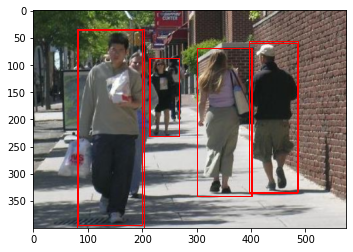

In [ ]:
@torch.no_grad()
def inference(model, img):
  model.eval()
  img_tensor = torch.tensor(img) / 255.
  img_tensor = img_tensor.permute(2, 0, 1)[None, :, :, :] ######### add normalization... in model.
  _, c, H, W = img_tensor.shape
  
  sH =  int(H * 400/min(H, W))
  sW =  int(W * 400/min(H, W))
  scale = 400/min(H, W)
  
  #sH, sW = int(H*scale), int(W*scale)
  print(f'sH: {sH}, sW: {sW}, HW : {H}, {W}')
  img_tensor = torchvision.transforms.functional.resize(
      img_tensor, size=(sH, sW))
  #GT_box = (GT_box * scale).int()

  #print(GT_mask[i].shape) #num_instances H W
  #GT_mask[i] = F.interpolate(GT_mask[i][None, :, :, :], size=(sH, sW), mode='nearest')[0]

  maxh = int(np.ceil(sH/32) * 32)
  maxw = int(np.ceil(sW/32) * 32)
  X = torch.zeros(1, 3, maxh, maxw)
  
  X[0, :c, :sH, :sW] = img_tensor[:, :, :]
  #print(X.shape)

  model.train()
  p = model(X)
  det = model.blocklist[-1][0]
  pobj, pbox, pcls = [], [], []
  for i, pi in enumerate(p):
    anchors = det.anchors[i]
    strides = det.strides[i]
    
    #pi : N A ny nx C
    obj = pi[..., 0]
    box = pi[..., 1:5]
    cls = pi[..., 5:5+80]

    #print('hi', obj > 0)
    obj = obj.sigmoid()

    ny, nx = pi.shape[2], pi.shape[3] # N A ny nx C
    grid = Detect._make_grid(nx=nx, ny=ny) # ny nx 2
    #print(grid)
    box[..., 0:2] = (grid[None, None, :, :, :] + box[..., 0:2].sigmoid()*2 - 0.5) * strides
    box[..., 2:4] = (box[..., 2:4].sigmoid()*2) ** 2 * anchors.view(1, -1, 1, 1, 2) * strides
   
    cls = cls.softmax(dim=-1)

    pobj.append(obj.view(1, -1, 1))
    #print(box.shape)
    pbox.append(box.clone().view(1, -1, 4))
    pcls.append(cls.view(1, -1, 80))

  pobj = torch.cat(pobj, dim=1)[0] # N -1 1
  pbox = torch.cat(pbox, dim=1)[0]
  pcls = torch.cat(pcls, dim=1)[0]
  #print((pobj > 0.9).nonzero())
  pconf = (pcls * pobj).max(dim=1)[0]
  pbox = xywh_to_xxyy(pbox)
  #print(pcls.shape, pobj.shape)
  ### NMS
  #j = torchvision.ops.boxes.nms(boxes=pbox, scores=pconf, iou_threshold=0.7)
  #pconf = pconf[j]
  #pbox = pbox[j]
  #pcls = pcls[j]

  ### thres
  print(pconf[50:])
  conf_thres = 0.9
  j = (pconf > conf_thres)
  pconf = pconf[j]
  pbox = pbox[j]
  pcls = pcls[j]

  tbox = torch.stack([torch.tensor(b) for b in boxlist], dim=0)
  print('tbox')
  print(tbox)
  print('pbox')
  print(pbox)

  #print(GIoUxywh(xxyy_to_xywh(tbox[0][None]), xxyy_to_xywh(pbox[8][None])))

  vis = Visualizer(img_tensor.permute(0, 2, 3, 1)[0].numpy())  
  ### mask reshaping
  vis.draw_box_predictions(pbox)
  #vis.draw_box_predictions(torch.stack([torch.tensor(b) for b in boxlist], dim=0), blue=True)
  
img, clslist, boxlist, masklist = ds[0]
print(boxlist)

inference(yolo, img)
